# Lecture 7 - Classification & Regression (Linear Regression)

Linear Regression is one if the most fundamental and popular techniques to solve regression tasks. It's simplicity has several advantages:

* The best parameter values can be found analytically (in many to most cases)
* There are no "fundamental" hyperparameters that need tuning. Adding polynomial terms for Polynomial Linear Regression is more on the level of data preprocessing. Different methods for regularization are more inherent to Linear Regression itself
* Linear Regression are typically easy to interpret by looking at the coefficients of the model

Whether Linear Regression shows (very) good model performance compared to more sophisticated models, typically depends on the nature of the data.


Let's get started...

## Setting up the notebook

Specify how plots get rendered

In [1]:
%matplotlib notebook

Make all required imports. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

## Working with Toy Data (CSI Example)

The following toy data is CSI example used in the lecture, where the goal is to estimate a person's height based on the size of a shoe print. so 20 (shoe print size, height)-pairs have been collected. Note that the code below directly adds the constant term $x_0=1$ to the data matrix `X`.

You can do a `print(X)` to see how the data matrix looks like in the end.

In [4]:
data = np.array([
    (31.3, 180.3), (29.7, 175.3), (31.3, 184.8), (31.8, 177.8),
    (31.4, 182.3), (31.9, 185.4), (31.8, 180.3), (31.0, 175.5),
    (29.7, 177.8), (31.4, 185.4), (32.4, 190.5), (33.6, 195.0),
    (30.2, 175.3), (30.4, 180.3), (27.6, 172.7), (31.8, 182.9),
    (31.3, 189.2), (34.5, 193.7), (28.9, 170.3), (28.2, 173.8)
])

# Convert input and outputs to numpy arrays; makes some calculations easier
X = np.ones((data.shape[0], 2))
X[:,1] = data[:,0]
y = data[:,1]

Since we only have 1 input feature, it's always good to plot the data.

<IPython.core.display.Javascript object>


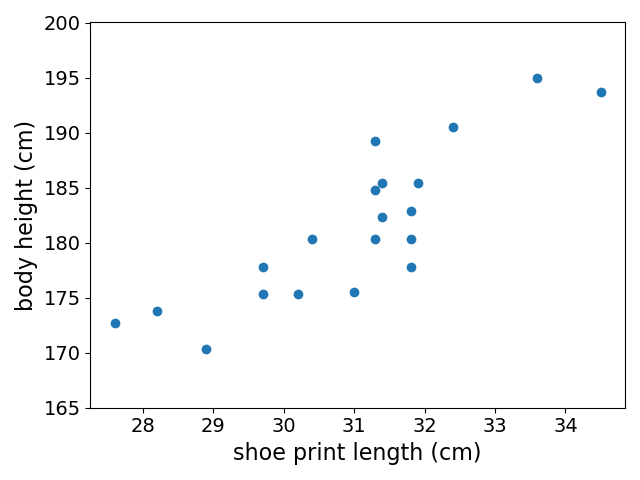

In [5]:
plt.figure()
plt.axes().set_ylim([165, 200])
plt.tick_params(labelsize=14)
plt.scatter(X[:,1], y)
plt.xlabel('shoe print length (cm)', fontsize=16)
plt.ylabel('body height (cm)', fontsize=16)
plt.tight_layout()
plt.show()

The plot shows that there is a reasonably good linear relation ship between the shoe print size and the height of a person. Hence one can justifiably use Linear Regression to find a good fit of the data.

Let's extend this plot to also show 3 possible regression lines; again, matching the example from the lecture slides. You can of course change the values of `theta_i` to see the effects.

<IPython.core.display.Javascript object>


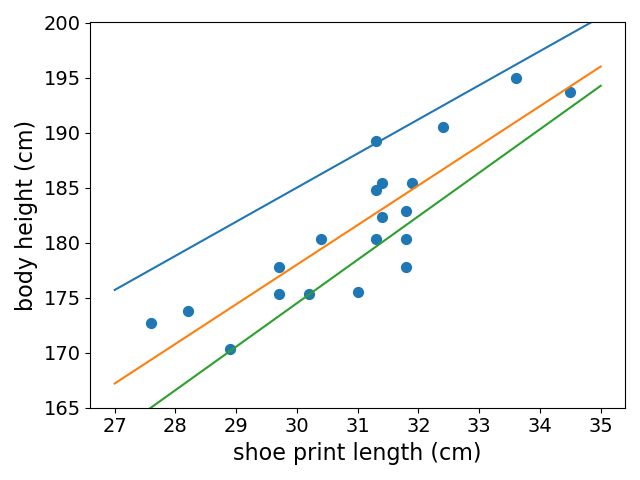

In [6]:
theta_1 = np.array([92, 3.1])
theta_2 = np.array([70, 3.6])
theta_3 = np.array([56, 3.95])


x_0 = [27.0, 35.0]
y_1 = [ (theta_1[1] * x + theta_1[0]) for x in x_0 ]
y_2 = [ (theta_2[1] * x + theta_2[0]) for x in x_0 ]
y_3 = [ (theta_3[1] * x + theta_3[0]) for x in x_0 ]

plt.figure()
plt.ylim([165, 200])
plt.tick_params(labelsize=14)
plt.scatter(X[:,1], y, s=50)
plt.plot(x_0, y_1)
plt.plot(x_0, y_2)
plt.plot(x_0, y_3)

plt.xlabel('shoe print length (cm)', fontsize=16)
plt.ylabel('body height (cm)', fontsize=16)
plt.tight_layout()
plt.show()

We made the argument that the orange line fits the data best as minimizes the average error between the prediction (described) by the regression line and the true values for the body height.

### Calculate Loss

We formalized this notion of the error (or loss, cost) using the Root Mean Squared Error (RSME). It sums up the  squared differences between predictions and true value and normalizes it by the number of data samples (i.e., averaging).

$$
\begin{align*}
L & = \frac{1}{n}\sum_{i=1}^n (\hat{y_i} - y_i)^2 \\
  & = \frac{1}{n}\sum_{i=1}^n (\theta^Tx_i - y_i)^2 \\
  & = \frac{1}{n}\lVert X\theta - y\rVert^2
\end{align*}
$$

Note how the sum over all data samples can be rewritten using matrix/vector representations. In practice, this makes both the math and the implementation much more convenient (and even faster since we can use fast matrix/vector operations provided by numpy).

The following method `calc_loss()` simply implements the formula above

In [7]:
def calc_loss(X, y, theta):
    
    # Calculate predicted value
    h = X.dot(theta)
    
    # Calculate square error for each ground truth / prediction pair
    e_squared = np.square(h - y)
    
    # Calculate loss as normalized sum of all squared errors
    loss = (1 / X.shape[0]) * np.sum(e_squared)
    
    # Of course, we could just use the method to caluclate the MSE from scikit-learn
    #loss = mean_squared_error(y, h)
    
    # Return the loss
    return loss


Using this method, we can calculate the losses for the `theta_i` values as define above

In [8]:
print("MSE loss for blue line:   {:.3f}".format(calc_loss(X, y, theta_1)))
print("MSE loss for orange line: {:.3f}".format(calc_loss(X, y, theta_2)))
print("MSE loss for green line:  {:.3f}".format(calc_loss(X, y, theta_3)))
print("MSE loss for random line: {:.3f}".format(calc_loss(X, y, np.array([100, -5]))))

MSE loss for blue line:   57.473
MSE loss for orange line: 11.927
MSE loss for green line:  20.833
MSE loss for random line: 56129.232


In line with our initial intuition, the orange line yields indeed the best loss. However, one can argue that the blue and green lines are not really that bas either, since the loss is still comparable, contrast to a much more random setting for `theta`.

### Find the Best $\theta$ Using Random Search

For this really simple dataset with just one input feature which in turn requires to fit only two parameters $\theta_0$ and $\theta_1$ we can in fact try a random search to find the best parameter values. In practice, this is of course not a viable approach.

Note that the parameter search is not truly random as we quite limit the range of possible values for $\theta_0$ and $\theta_1$. Identifying such meaningful ranges can be done by eyeballing the data or basic EDA. But again, random search is not practical method anyway.

In [9]:
num_iterations = 1000

# Keep track of all data points for a plot
xs, ys, zs = [], [], []

# Initialize parameters
best_loss, best_theta0, best_theta1 = float("inf"), None, None

for i in range(num_iterations):
    
    # Select a random value for theta_0 and theta_1
    theta = np.array([np.random.uniform(0.0,100.0), np.random.uniform(0.0, 5.0)])
    
    # Calculate loss for selected m and b
    loss = calc_loss(X, y, theta)
    
    # Remember current parameter values and loss for plotting
    xs.append(theta[0])
    ys.append(theta[1])
    zs.append(loss)
    
    # If the loss is lower than the currently best loss, remember all parameters
    if loss < best_loss:
        best_loss = loss
        best_theta0 = theta[0]
        best_theta1 = theta[1]
        
print("The best values are: m={:.3f}, b={:.3f} (loss={:.3f})".format(best_theta0, best_theta1, best_loss))

The best values are: m=73.711, b=3.482 (loss=11.992)


As soon as `num_terations` is large enough, we are very likely to get decent estimate for $\theta_0$ and $\theta_1$, which shows when we plot the corresponding regression line.

<IPython.core.display.Javascript object>


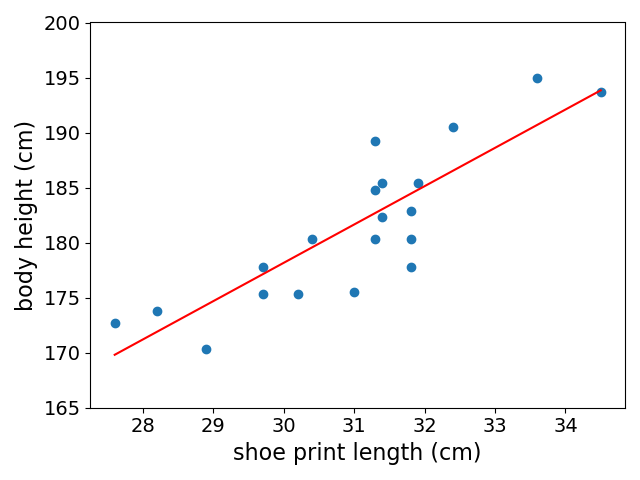

In [10]:
x_line = [np.min(X[:,1]), np.max(X[:,1])]
y_line = [ (best_theta1 * x + best_theta0) for x in x_line ]

plt.figure()
plt.ylim([165, 200])
plt.tick_params(labelsize=14)
plt.scatter(X[:,1], y)
plt.plot(x_line, y_line, c='red')
plt.xlabel('shoe print length (cm)', fontsize=16)
plt.ylabel('body height (cm)', fontsize=16)
plt.tight_layout()
plt.show()

Since we kept track of the loss for all combinations of $\theta_0$ and $\theta_1$, we can also plot the loss function as a 3d scatter plot.

<IPython.core.display.Javascript object>


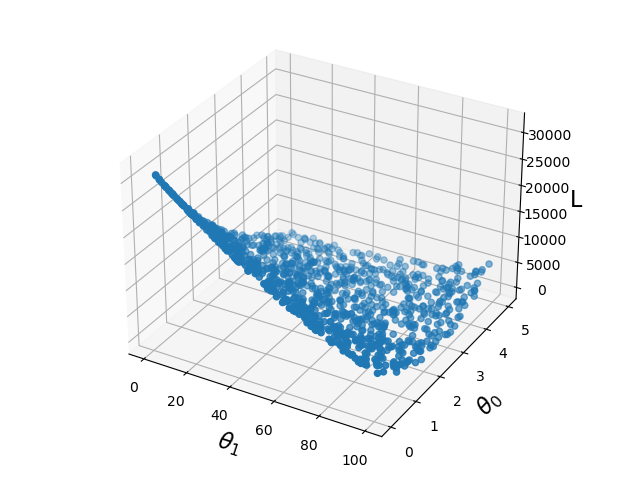

/home/vdw/env/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


In [11]:
xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)

fig = plt.figure()
plt.tick_params(labelsize=18)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$\theta_1$', fontsize=16)
ax.set_ylabel(r'$\theta_0$', fontsize=16)
ax.set_zlabel('L', fontsize=16)
plt.tight_layout()
surf = ax.scatter(xs, ys, zs)
plt.show()

The plot shows -- maybe not fully convincingly -- that the loss function is convex, i.e., there is a unique minimum of the loss

### Performing Linear Regression

In practice, of course, Linear Regression performed the smart way. As the nature of the loss function for Linear Regression allows it, the best values for $\theta$ can be found analytically. In the lecture, we have seen how to take the loss function L

$$
L = \frac{1}{n}\lVert X\theta - y\rVert^2
$$

calculate the derivative of L w.r.t. to $\theta$, set the derivative to 0 and solve for $\theta$ to arrive at the **Normal Equation**

$$
\theta = (X^TX)^{-1} X^Ty
$$

that allows us to calculate the best values of $\theta$.

As Linear Regression is one of the most fundamental but also popular methods, scikit-learn provides of course an implementation: [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). An important parameter of this implementation is `fit_intercept` whether to calculate the intercept $\theta_0$ or not. If set to False, no intercept will be used in calculations (i.e. data is expected to be centered). This is because the scikit-learn implementation treats $\theta_0$ (`intercept_`) and the other $\theta_{i\neq 0}$ (`coef_`) separately.

As we already added the constant term to our data matrix $X$, the $\theta_0$ is already part of `coef_` and we can set `fit_intercept=False`.

In [12]:
linreg = LinearRegression(fit_intercept=False).fit(X, y)

print('Intercept: {}, Coefficients: {}'.format(linreg.intercept_, linreg.coef_))

theta0, theta1 = linreg.coef_[0], linreg.coef_[1]

Intercept: 0.0, Coefficients: [69.45528793  3.61092267]


In practice, we do not usually add the constant term to the data ourselves. In this case, we typically set `fit_intercept=True` and find $\theta_0$ in `intercept_`

In [13]:
X_raw = data[:,0].reshape(-1,1)
linreg = LinearRegression(fit_intercept=True).fit(X_raw, y)

print('Intercept: {}, Coefficients: {}'.format(linreg.intercept_, linreg.coef_))

theta0, theta1 = linreg.intercept_, linreg.coef_[0]

Intercept: 69.4552879301803, Coefficients: [3.61092267]


Both results are of course the same, but it's a detail one has to consider

In [14]:
print("The best values are: theta0={:.3f}, theta1={:.3f}".format(theta0, theta1))

The best values are: theta0=69.455, theta1=3.611


Now that we found the best data for $\theta$ we can plot the respective regression line. Of course, it looks very similar the the orange regression line above, and also to the one found through random search of we search long enough :).

<IPython.core.display.Javascript object>


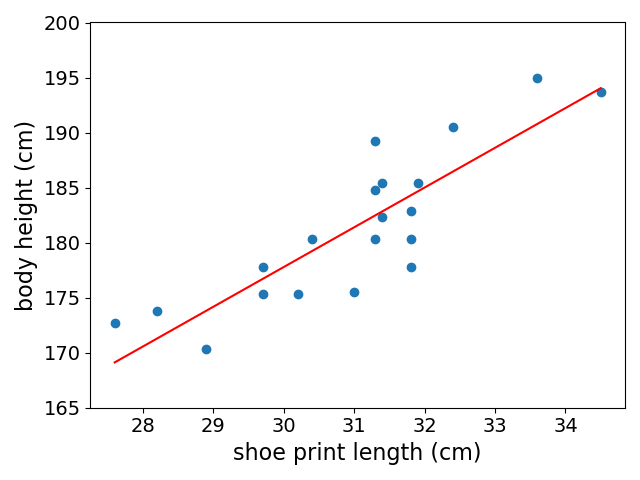

In [15]:
x_line = [np.min(X_raw), np.max(X_raw)]
y_line = [ (theta1 * x + theta0) for x in x_line ]

plt.figure()
plt.ylim([165, 200])
plt.tick_params(labelsize=14)
plt.scatter(X_raw, y)
plt.plot(x_line, y_line, c='red')
plt.xlabel('shoe print length (cm)', fontsize=16)
plt.ylabel('body height (cm)', fontsize=16)
plt.tight_layout()
plt.show()

### Predict Height of Suspect

No that we know how to fit a Linear Regression model on your example dataset, we can finally predicted height of the suspect based on the shoe print we found. Recall that the size of the shoe print size was 32.2 cm.

In [16]:
y_pred = linreg.predict([[32.2]])

print('The estimated hight of the suspect is: {:.1f}'.format(y_pred.squeeze()))

The estimated hight of the suspect is: 185.7


-------------------------------------------

## Polynomial Linear Regression

A common misconception is that Linear Regression always yields straight regression *line* (or flat plane or hyperplane in higher dimensions). By transforming the data to include polynomial terms based on the input features, more complex curves are possible.

As an example, we use a toy dataset we've seen in earlier lectures. In this case, we do not explicitly add the constant term to the data matrix $X$.

In [17]:
data = np.array([
    [2.0, 11.0], [18.0, 9.0], [10.0, 4.0], [2.5, 9], [4, 9], [4.5, 8.5],
    [9.5, 4.5], [8.5, 5], [5.5, 5.5], [4.5, 6.5], [3.8, 6], [7.5, 6.5], [7.7, 7.3],
    [11.5, 6], [12.5, 4.5], [13.5, 4.5], [13, 3.5], [14, 6.2], [14.7, 3.7],
    [14.7, 3.7], [15.2, 6], [16.5, 7]
])

X_raw = data[:,0].reshape(-1, 1)
y = data[:,1]

print(X_raw.shape, y.shape)

(22, 1) (22,)


Again, we have only one input feature, so let's plot the the data.

<IPython.core.display.Javascript object>


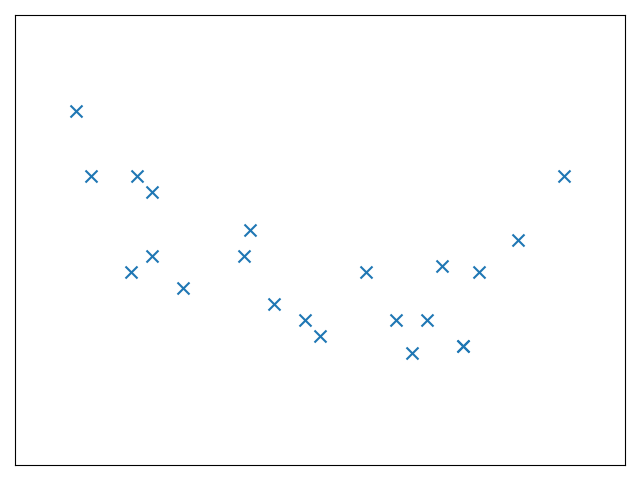

In [18]:
t1 = np.arange(0., 20., 0.01)
plt.figure()
plt.xlim([0.0, 20.0])
plt.ylim([0.0, 14.0])
plt.scatter(X_raw, y, marker='x', s=75)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.show() 

One can already see that fitting that a straight line probably won't yield a good fit. Hence the idea of Polynomial Linear Regression to transform the data to add polynomial terms up to a degree of $p$:

$$
\hat{y_i} = \theta_0 + \theta_1x_{i} + \theta_2x^2_{i} + ... + \theta_px^p_{i}
$$

Conveniently, scikit-learn provides [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to automate this transformation. The main parameter is the maximum degree $p$ for the polynomial terms.

In the following, try different values for the maximum degree and see the effects on the final results.

In [36]:
poly = PolynomialFeatures(1)
#poly = PolynomialFeatures(2)
#poly = PolynomialFeatures(3)
#poly = PolynomialFeatures(4)
poly = PolynomialFeatures(5)
poly = PolynomialFeatures(8)
X_poly = poly.fit_transform(X_raw)

When fitting a Linear Regression model, note that we set `fit_intercept=False`, as [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) will explicitly add the constant term, even for $p=1$.

In [37]:
poly_reg = LinearRegression(fit_intercept=False).fit(X_poly, y)

np.set_printoptions(suppress=True)

print(np.around(poly_reg.coef_, 2))

[17.35  1.33 -5.73  2.57 -0.53  0.06 -0.    0.   -0.  ]


To plot the regression line, we simple predict the output values for a series of input values in the range of the dataset and plot the result as line.

<IPython.core.display.Javascript object>


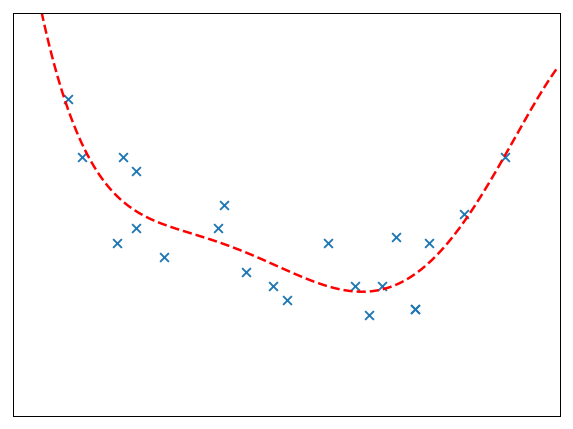

In [20]:
x_test = np.arange(0., 20., 0.1)
y_test = poly.fit_transform(x_test.reshape(-1,1))

plt.figure()
plt.xlim([0.0, 20.0])
plt.ylim([0.0, 14.0])
plt.scatter(X_raw, y, marker='x', s=50)
plt.plot(x_test, poly_reg.predict(y_test), c='red', lw=2, linestyle='--')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.show() 

For increasing values for the maximum polynomial degree, the regression line becomes more and more "wiggly" as there model has more and more capacity to fit the training data. Although we do not explicitly quantify it, this will very likely lead of severe overfitting as it fails to generalize the data.

Intuitively, setting $p=2$ yields the best fit. But again, in practice, this needs to be properly evaluated, as we will illustrate using a real-world dataset below


------------------------------------------------------------------

## Linear Regression of Howell Dataset

The [Howell Dataset](https://github.com/rmcelreath/rethinking/blob/master/data/Howell1.csv) contains the weight, height, and age for 544 people.

### Prepared Training & Test Data

#### Load Dataset from File

For this example, we consider only man -- or woman if you change the code below -- to simply the data as it removes the categorical variable. In principle, this is not a problem as this feature is binary.

In [21]:
df = pd.read_csv('data/Howell1.csv', sep=';')

# We consider only males to keep it simple
df = df[df['male'] == 1]

# The rows are sorted, so let's shuffle them
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Show the first 5 columns
df.head()

,height,weight,age,male
0,157.480,45.869491,41.0,1
1,159.385,50.178615,63.0,1
2,123.190,20.014747,12.0,1
3,168.275,54.600000,41.0,1
4,80.010,9.865626,1.0,1


#### Generate Training & Test Data

Ignoring the sex, there are 3 features: `height`, `weight`, `age`. In the following, we aim to predict a man's weight given his a age and height. Feel free to change this to any other combination, e.g., predicting a man's age given his height and weight.

In [22]:
# Convert data to numpy arrays
X = df[['age', 'height']].to_numpy()
y = df[['weight']].to_numpy().squeeze()

# Split dataset in to training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_test)))

Size of training set: 205
Size of test: 52


#### Normalize Data via Standardization

As we discussed in the lecture, for basic Linear Regression, there's no fundamental need to normalize the data -- and even a problem depending on how we want to interpreted the learned coefficient. However, since we also perform Ridge Regression later on which uses regularization, we do normalize the data via standardization.

Feel free to skip this step to see any effects on the results.

In [5]:
X_train = np.array([[0], [1], [1]])

print(X_train)

# We fit the scaler based on the training data only
scaler = StandardScaler().fit(X_train)

# Of course, we need to convert both training and test data
X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

print(X_train)

[[0]
 [1]
 [1]]
[[-1.41421356]
 [ 0.70710678]
 [ 0.70710678]]


The data is now ready to perform Linear Regression. In the following, to keep things simple, we do not use K-Fold Cross-Validation or similar methods but directly compare different hyperparameters using the test set.

### Linear Regression

We first apply basic [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) which does not perform any regularization. However, we want to transform our data to include polynomial and interaction terms up to a degree of $p$ to see which degree yields the best results.

Recall from the lecture that the number of terms given a polynomial degree of $p$ a number of input features $d$ is

$$
\#terms = \binom{p+d}{p}
$$

Since our dataset has 2 input features, this equation simplifies to

$$
\#terms = \binom{p+2}{2}
$$

Below we consider $p$ as our hyperparameter, i.e., we transform the dataset using different polynomial degrees, apply Logistic Regression, and check the Means Squares Error (MSE) for each setup.

In [24]:
for p in range(1, 10):
    
    # Transform data w.r.t to degree of polynomial p
    poly = PolynomialFeatures(p)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    # Train Linear Regressor or transformed data
    # fit_intercept=False since for p=1, transformation adds constant term to data
    poly_reg = LinearRegression(fit_intercept=False).fit(X_train_poly, y_train)

    # Predict values for training and test set
    y_train_pred = poly_reg.predict(X_train_poly)
    y_test_pred = poly_reg.predict(X_test_poly)
    
    # Calculate MSE 
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    
    print('Degree of polynomial: {} => MSE (train/test): {:.2f}/{:.2f} (#terms: {})'.format(p, mse_train, mse_test, X_train_poly.shape[1]))

Degree of polynomial: 1 => MSE (train/test): 23.05/25.82 (#terms: 3)
Degree of polynomial: 2 => MSE (train/test): 11.33/21.04 (#terms: 6)
Degree of polynomial: 3 => MSE (train/test): 10.26/18.40 (#terms: 10)
Degree of polynomial: 4 => MSE (train/test): 9.86/24.21 (#terms: 15)
Degree of polynomial: 5 => MSE (train/test): 9.70/25.11 (#terms: 21)
Degree of polynomial: 6 => MSE (train/test): 9.44/29.21 (#terms: 28)
Degree of polynomial: 7 => MSE (train/test): 8.43/46.17 (#terms: 36)
Degree of polynomial: 8 => MSE (train/test): 8.14/120.31 (#terms: 45)
Degree of polynomial: 9 => MSE (train/test): 7.70/2675.64 (#terms: 55)


According to these results, we achieve the lowest MSE with $p=3$. We can also see that the MSE explodes once $p$ gets too large due to overfitting. While the training errors goes down since higher polynomials allow for a better fit of the training data, the fit fails to generalize and thus yielding poor performance on the test data.

You can increase the value of $p$ for the loop even further to see how bad it quickly gets.

### Ridge Regression

We introduced the concept of regularization to address the problem of overfitting. In a nutshell, regularization extends the loss function adding a term that punishes large values for $\theta$ to smoothen the regression line, i.e., to generalize better.

In the lecture, we use the squared L2 norm of $\theta$ for regularization. Linear Regression using the squared L2 norm is also called Ridge Regression. (There are other ways to define the regularization but that's not so important here.)

$$
L = \frac{1}{n}\lVert X\theta - y\rVert^2 + \lambda\frac{1}{n}\lVert \theta \rVert^2_2
$$

There are two common approaches to implement regularization. In one case, $theta_0$ (i.e., the intercept/bias) is not considered to be subject to regularization. There are theoretical arguments for that that are again beyond the scope of this notebook. In this case, the Normal Equation for Ridge Regression is

$$
\theta = (X^TX + \lambda \begin{bmatrix}
0 & &  &   \\
 & 1 &  &  \\
 &  & \ddots & \\
 &  &  & 1 \\
\end{bmatrix} )^{-1} X^Ty
$$

In the other approach, all $\theta_i$ are considered for regularization. This simplifies the Normal Equation to

$$
\theta = (X^TX + \lambda I )^{-1} X^Ty
$$

where $I$ is the identity matrix with 1s in diagonal and 0s everywhere else.

We can now perform the same evaluation is above, but using [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) Regression. Again, we test different values for the polynomial degree $p$. The regularization parameter $\lambda$ in the formula above is represented by parameter `alpha`. `alpha=1.0` is the default value, but feel free to change it and compare the results.

In [25]:
for p in range(1, 10):
    
    # Transform data w.r.t to degree of polynomial p
    poly = PolynomialFeatures(p)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    # Train Linear Regressor or transformed data
    # fit_intercept=False since for p=1, transformation adds constant term to data
    poly_reg = Ridge(alpha=1.0, fit_intercept=False).fit(X_train_poly, y_train)

    # Predict values for test set
    y_pred = poly_reg.predict(X_test_poly)
    
    # Calculate MSE 
    mse = mean_squared_error(y_test, y_pred)
    
    print('Degree of polynomial: {} => MSE: {:.2f} (#terms: {})'.format(p, mse, X_train_poly.shape[1]))

Degree of polynomial: 1 => MSE: 25.99 (#terms: 3)
Degree of polynomial: 2 => MSE: 21.58 (#terms: 6)
Degree of polynomial: 3 => MSE: 21.40 (#terms: 10)
Degree of polynomial: 4 => MSE: 21.41 (#terms: 15)
Degree of polynomial: 5 => MSE: 23.79 (#terms: 21)
Degree of polynomial: 6 => MSE: 24.07 (#terms: 28)
Degree of polynomial: 7 => MSE: 23.84 (#terms: 36)
Degree of polynomial: 8 => MSE: 25.42 (#terms: 45)
Degree of polynomial: 9 => MSE: 52.07 (#terms: 55)


While the lowest MSE is still for $p=3$, the differences compared to $p=2$ and $p=4$ are now much smaller due to regularization. More importantly, the MSE does no explode for larger values of $p$.

## Summary

We have seen that applying Linear Regression in practice is rather straightforward as the model itself is rather simple. Particularly the (kind of) absence of important hyperparameters makes simplifies finding the best Linear Regression model for a given dataset. It is therefore often a first model to apply to quickly get a first baseline to compare agains more sophisitcated model -- which typically take much longer to train. 

As it is the case with many other models, great care has to be taken when preparing the data as Linear Regression cannot handle categorical features. Such features need to be encoded as numerical features (e.g., using one-hot encoding) or, if potentially not that important, simply removed (at least in the beginning to get some first results very fast).